In [167]:
from typing import List
import re
from math import log
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [168]:
def matching_graph(d: int, probabilities: List[float]) -> nx.Graph:
    """Get the matching graph for the repetition code.
    
    Arguments:
    d - Distance of the code. Should be odd.
    probabilities - A list of bit-flip probablities.
    
    Returns:
    M - The matching graph for this code and error model."""

    assert d >= 3, f"Distance must be >= 3, but got {d}."
    assert d % 2 != 0, f"Distance d must be odd, but got {d}."

    matching_graph = nx.Graph()
    # First add the "extra nodes" for the leftmost and rightmost qubits.
    matching_graph.add_node("r1")
    matching_graph.add_node("r2")
    # Then add the regular syndromes
    for i in range(d - 1):
        matching_graph.add_node(f"s{i}")
    # Add an edge of weight w = log((1-p_i)/p_i) for each qubit.
    for i in range(d):
        w = log((1. - probabilities[i]) / probabilities[i])
        if i == 0:
            matching_graph.add_edge("r1", "s0", weight=w, label="q0")
        elif i == d - 1:
            matching_graph.add_edge("r2", f"s{i-1}", weight=w, label=f"q{i}")
        else:
            matching_graph.add_edge(f"s{i-1}", f"s{i}", weight=w, label=f"q{i}")
    return matching_graph

In [169]:
def error_to_syndrome(err: np.ndarray) -> np.ndarray:
    """Convert a list of bit-flips into a the repetition code syndrome."""

    d = err.size
    check = np.zeros((d-1, d), dtype=bool)
    for i in range(d - 1):
        check[i, i] = True
        check[i, i + 1] = True
    return ((check.astype(int) @ err.astype(int)) % 2).astype(bool)

In [170]:
def syndrome_graph(matching: nx.Graph, syndrome: np.ndarray) -> nx.Graph:
    """Gets the syndrome graph for a binary syndrome vector given the
    matching graph."""

    d = len(matching.nodes()) - 1
    assert syndrome.size == d - 1

    syndrome_nodes: List[str] = []
    for i, b in enumerate(syndrome):
        if b:
            if i == 0:
                syndrome_nodes.append("r1")
                syndrome_nodes.append("s0")
            elif i == len(syndrome) - 1:
                syndrome_nodes.append(f"s{i-1}")
                syndrome_nodes.append("r2")
            else:
                syndrome_nodes.append(f"s{i}")
    # Build a graph with a node for each 1 in the syndrome.
    # The weight between two nodes will be the distance on the matching graph.
    syndrome_gr = nx.Graph()
    for snode in syndrome_nodes:
        syndrome_gr.add_node(snode)
    assert set(syndrome_gr.nodes()).issubset(matching.nodes())
    for sn1 in syndrome_gr.nodes():
        for sn2 in syndrome_gr.nodes():
            if sn1 != sn2:
                length = nx.shortest_path_length(matching, sn1, sn2, weight='weight')
                syndrome_gr.add_edge(sn1, sn2, weight=length)
    return syndrome_gr

In [171]:
def repetition_tanner_graph(d: int) -> nx.Graph:
    """Get the Tanner graph for a repetition code."""

    assert d % 2 != 0
    assert d >= 3

    tanner_graph = nx.Graph()
    for i in range(d):
        tanner_graph.add_node(f"q{i}")
        if i == 0:
            tanner_graph.add_node(f"r1")
            tanner_graph.add_node(f"s0")
            tanner_graph.add_edge("q0", "r1")
            tanner_graph.add_edge("q0", "s0")
        elif i == d - 1:
            tanner_graph.add_node("r2")
            tanner_graph.add_edge(f"q{i}", "r2")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
        else:
            tanner_graph.add_node(f"s{i}")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
            tanner_graph.add_edge(f"q{i}", f"s{i}")
    return tanner_graph

In [172]:
def matching_to_correction(matching, tanner_graph) -> np.ndarray:
    """Convert the minimum-weight matching to a binary correction."""

    # Count qubits in the Tanner graph.
    nq = 0
    for node in tanner_graph.nodes():
        if 'q' in node:
            nq += 1

    correction = [False] * nq
    for n1, n2 in matching:
        n1_neighbors = tanner_graph.neighbors(n1)
        n2_neighbors = tanner_graph.neighbors(n2)
        common_qubits = set(n1_neighbors) & set(n2_neighbors)
        qubit_node_name = list(common_qubits)[0]
        idx = int(re.search(r'\d+', qubit_node_name).group()) 
        correction[idx] = True
    return np.array(correction)

In [177]:
d = 3
probs = [0.1] * d
err = np.array([True, False, True])
syndrome = error_to_syndrome(err)
print(f"syndrome = {syndrome}")

tanner_graph = repetition_tanner_graph(d)
matching_gr = matching_graph(d, probs)
syndrome_gr = syndrome_graph(matching_gr, syndrome)
matching = nx.min_weight_matching(syndrome_gr)
print("matching =", matching)
correction = matching_to_correction(matching, tanner_graph)
print(f"correction = {correction}")
print(correction ^ err)

syndrome = [ True  True]
matching = {('s0', 'r1')}
correction = [ True False False]
[False False  True]


{'q0': Text(0.3583914901392784, 0.7004514139119399, 'q0'),
 'r1': Text(0.5200404257318589, 0.983919552084926, 'r1'),
 's0': Text(0.17290829944455588, 0.3661921200124417, 's0'),
 'q1': Text(-0.014610192181740287, 0.007267946468370204, 'q1'),
 's1': Text(-0.19338287107632562, -0.35464169577143273, 's1'),
 'q2': Text(-0.3547344794656534, -0.7031893367062445, 'q2'),
 'r2': Text(-0.48861267259197394, -0.9999999999999999, 'r2')}

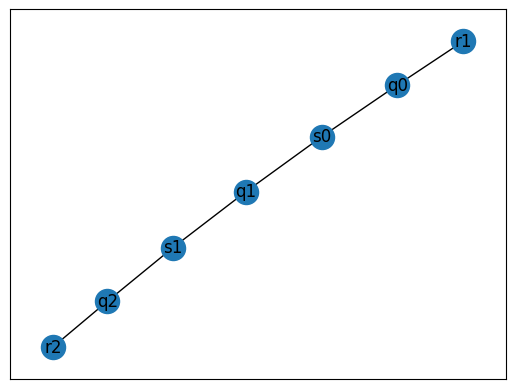

In [178]:
plt.figure()
pos = nx.spring_layout(tanner_graph)
nx.draw_networkx_nodes(tanner_graph, pos)
nx.draw_networkx_edges(tanner_graph, pos)
nx.draw_networkx_labels(tanner_graph, pos)

{'r1': Text(-0.05981509797221675, 0.9999806201086644, 'r1'),
 'r2': Text(0.05978063255890298, -1.0, 'r2'),
 's0': Text(-0.02117757696622272, 0.35444750078458376, 's0'),
 's1': Text(0.021212042379536562, -0.3544281208932479, 's1')}

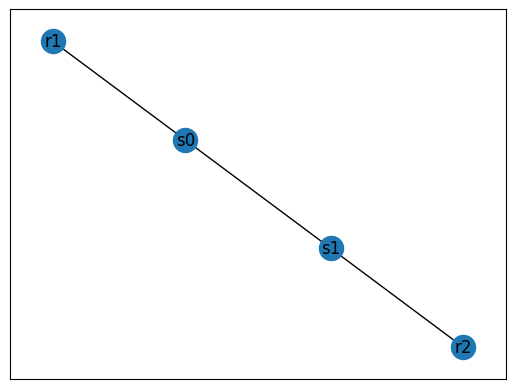

In [179]:
plt.figure()
pos = nx.spring_layout(matching_gr)
nx.draw_networkx_nodes(matching_gr, pos)
nx.draw_networkx_edges(matching_gr, pos)
nx.draw_networkx_labels(matching_gr, pos)

{'r1': Text(0.8698659852050963, -0.38962742707674086, 'r1'),
 's0': Text(-1.0, -0.28785789647573445, 's0'),
 'r2': Text(0.13013401479490413, 0.6774853235524744, 'r2')}

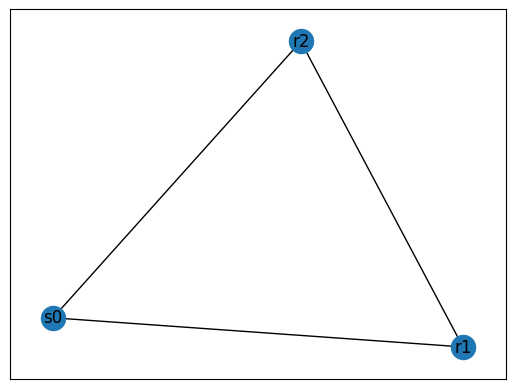

In [180]:
plt.figure()
pos = nx.spring_layout(syndrome_gr)
nx.draw_networkx_nodes(syndrome_gr, pos)
nx.draw_networkx_edges(syndrome_gr, pos)
nx.draw_networkx_labels(syndrome_gr, pos)